# Case Study 2 - Fairness

## The Task
Train a fair prognostic classifier for COVID-19 patients in Brazil.

### Imports
Lets get the imports out of the way. We import the required standard and 3rd party libraries and relevant Synthcity modules. We can also set the level of logging here, using Synthcity's bespoke logger. 

In [1]:
# Standard
import sys
import warnings
from pathlib import Path
from typing import Any, Tuple
from pprint import pprint
import itertools

# 3rd party
import numpy as np
import pandas as pd
import networkx as nx
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score, confusion_matrix, ConfusionMatrixDisplay


# synthcity
import synthcity
import synthcity.logger as log
from synthcity.utils import serialization
from synthcity.plugins import Plugins
from synthcity.metrics import Metrics
from synthcity.plugins.core.dataloader import (GenericDataLoader, SurvivalAnalysisDataLoader)
from synthcity.plugins.privacy.plugin_decaf import plugin as decaf_plugin

# Configure warnings and logging
warnings.filterwarnings("ignore")

# Set the level for the logging
log.remove()
# log.add(sink=sys.stderr, level="INFO")

/home/rob/miniconda3/envs/synth-lab/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the data
Next, we can load the data from file and formulate it as a classification problem. To do this we can simply set a time horizon and create an "is_dead_at_time_horizon" column. 

In [2]:
time_horizon = 14
X = pd.read_csv(f"../data/Brazil_COVID/covid_normalised_numericalised.csv")

X.loc[(X["Days_hospital_to_outcome"] <= time_horizon) & (X["is_dead"] == 1), f"is_dead_at_time_horizon={time_horizon}"] = 1
X.loc[(X["Days_hospital_to_outcome"] > time_horizon), f"is_dead_at_time_horizon={time_horizon}"] = 0
X.loc[(X["is_dead"] == 0), f"is_dead_at_time_horizon={time_horizon}"] = 0
X[f"is_dead_at_time_horizon={time_horizon}"] = X[f"is_dead_at_time_horizon={time_horizon}"].astype(int)

X.drop(columns=["is_dead", "Days_hospital_to_outcome"], inplace=True) # drop survival columns as they are not needed for a classification problem
display(X)

# Define the mappings of the encoded values in the Ethnicity column to the understandable values
ethnicity_mapper = {
    0: "Mixed",
    1: "White",
    2: "Black",
    3: "East Asian",
    4: "Indigenous",
}

,Age,Sex,Ethnicity,Region,Fever,Cough,Sore_throat,Shortness_of_breath,Respiratory_discomfort,SPO2,...,Cardiovascular,Asthma,Diabetis,Pulmonary,Immunosuppresion,Obesity,Liver,Neurologic,Renal,is_dead_at_time_horizon=14
0,1,0,0,2,1,1,0,1,1,1,...,0,1,0,0,0,0,0,0,0,0
1,75,0,0,2,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,61,1,0,2,1,1,0,1,0,0,...,1,0,1,0,0,0,0,0,0,1
3,81,1,0,2,1,1,0,1,1,1,...,1,0,1,0,0,0,0,0,0,1
4,86,0,0,2,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6877,52,0,0,4,1,1,0,1,1,1,...,0,0,1,0,0,0,0,0,0,0
6878,34,1,1,4,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6879,44,1,1,4,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6880,23,1,1,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Potential issue

The Brazilian population is made up of people of different ethnicities in different proportions. We should check the frequency for each ethnicity to see how evenly distributed our data is across ethnicity. Lets create a plot.

AxesSubplot(0.125,0.11;0.775x0.77)


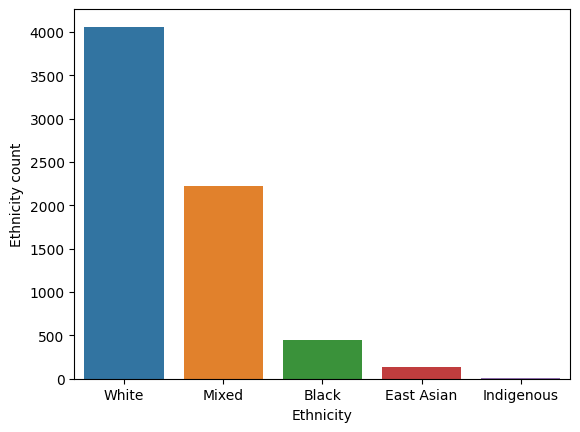

In [3]:
ethnicity_frequency_data = pd.DataFrame(data=X["Ethnicity"].value_counts().rename(ethnicity_mapper), columns=["Ethnicity"]).reset_index().rename(columns={"index": "Ethnicity", "Ethnicity": "Ethnicity count"})
print(sns.barplot(data=ethnicity_frequency_data, x="Ethnicity", y="Ethnicity count"))

The population in our dataset is overwhelmingly white an mixed, with little representation of black, East Asian and indigenous people. This poses a problem for us.

# The Problem
We need to train a prognostic classifier for the whole population. Having little representation from some parts of the population means that any classifier we train on this data is going to be susceptible to bias. Lets train an XGBoost classifier on the whole dataset then test it on each ethnicity. This will show us the extent of the problem, as we will be able to see any disparity between model performance across the different groups.

Evaluating accuracy on train set: 0.8126332106180972


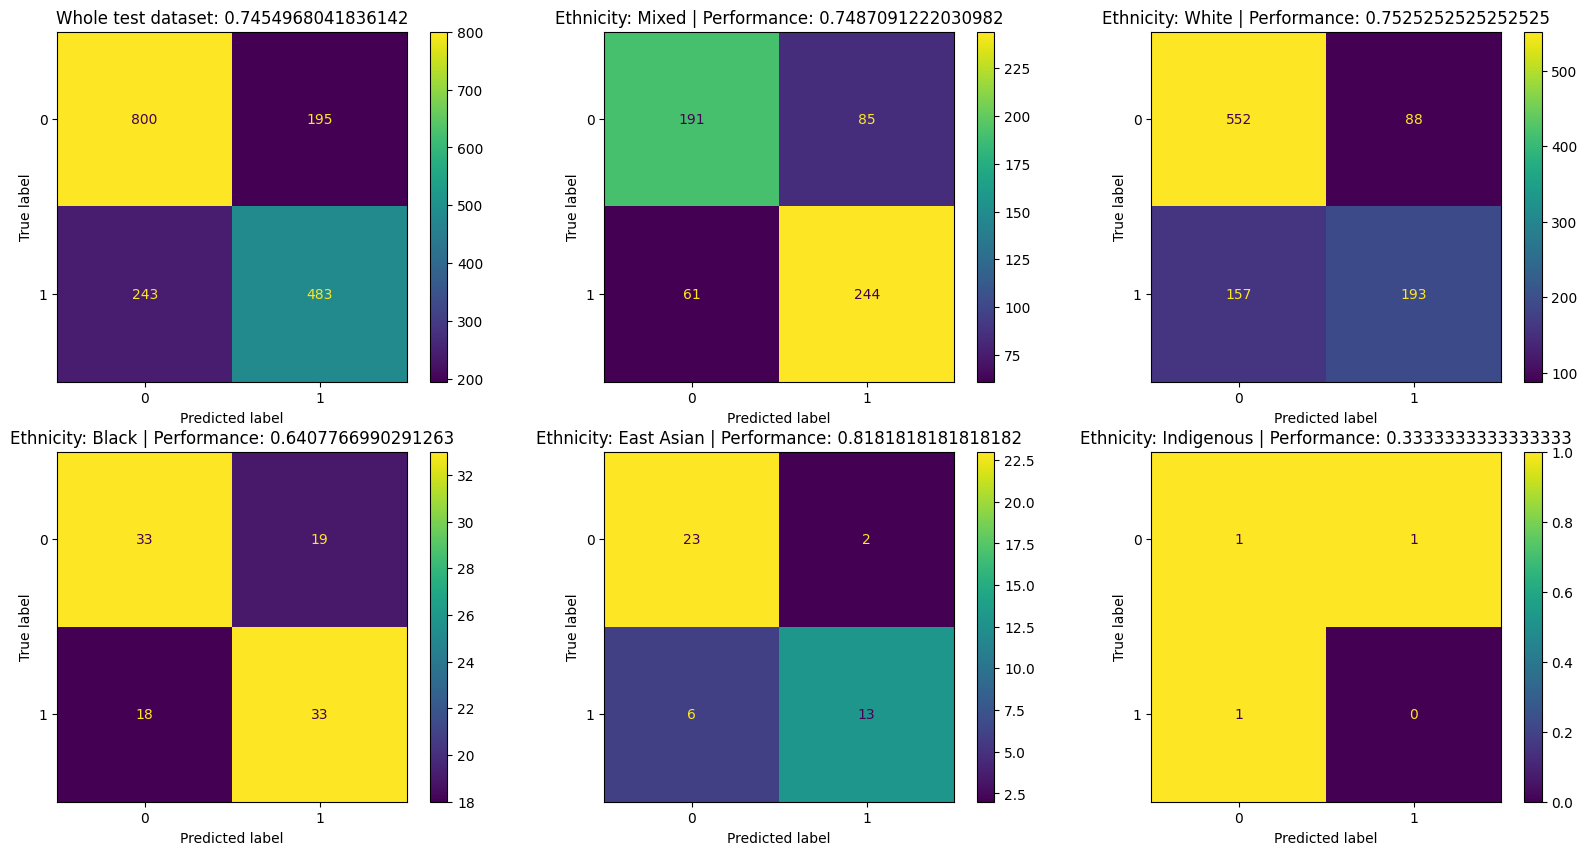

In [4]:
y = X["is_dead_at_time_horizon=14"]
X_in = X.drop(columns=["is_dead_at_time_horizon=14"])

X_train, X_test, y_train, y_test = train_test_split(X_in, y, random_state=4)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Train model on whole dataset
xgb_model = xgb.XGBClassifier(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8, 
    colsample_bytree=1, 
    gamma=1, 
    objective="binary:logistic",
    random_state=42,
)
xgb_model.fit(X_train, y_train)

ethnicity_idxes = X_in["Ethnicity"].unique()
ethnicity_idxes.sort()
ethnicities = [ethnicity_mapper[e] for e in ethnicity_idxes]

calculated_accuracy_score = accuracy_score(y_train, xgb_model.predict(X_train))
print(f"Evaluating accuracy on train set: {calculated_accuracy_score}")
y_pred = xgb_model.predict(X_test)
calculated_accuracy_score = accuracy_score(y_test, y_pred)


f, axes = plt.subplots(2, 3, figsize=(20, 10))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
disp.plot(ax=axes[0,0])
disp.ax_.set_title(f"Whole test dataset: {calculated_accuracy_score}")

for ethnicity_idx in ethnicity_idxes:
    X_test_per_ethnicity = X_test.loc[X_test["Ethnicity"] == ethnicity_idx]
    test_records_per_ethnicity_indicies = X_test_per_ethnicity.index

    y_pred = xgb_model.predict(X_test_per_ethnicity)
    y_true = y_test.iloc[test_records_per_ethnicity_indicies]

    calculated_accuracy_score = accuracy_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
    ax_index = [0, ethnicity_idx + 1] if ethnicity_idx <= 1 else [1, (ethnicity_idx + 1) % 3]
    disp.plot(ax=axes[ax_index[0], ax_index[1]])
    disp.ax_.set_title(f"Ethnicity: {ethnicity_mapper[ethnicity_idx]} | Performance: {calculated_accuracy_score}")
plt.show()

As you can see the performance of the model on the subpopulation whose ethnicity is Black is significantly worse than the overall performance. Interestingly, however the model performs better on the East Asian subpopulation. This is likely to be due to random chance, i.e. it happens that the East Asian patients in this sample had features that are good predictors of the outcome, but this would not necessarily be true for a bigger sample from the same population. The Indigenous population is so poorly represented in the dataset, with only 3 records, that it is difficult to even accurately assess performance. However, the indication we have from these three records suggests performance may be poor.

This confirms by using a naive method like the one above, we would create a model that systematically performs worse for people of one ethnicity compared to another. This unfairness must be addressed.

# The solution - Augment the dataset to improve the fairness

First we load the data with the GenericDataLoader. For this we need to pass the names of our `target_column` to the data loader. Then we can see the data by calling loader.dataframe() and we could also get the infomation about the data loader object with loader.info().


In [5]:
loader = GenericDataLoader(
    X,
    target_column=f"is_dead_at_time_horizon={time_horizon}",
    sensitive_features=["Age", "Sex", "Ethnicity", "Region"],
    random_state=42,
)

display(loader.dataframe())

,Age,Sex,Ethnicity,Region,Fever,Cough,Sore_throat,Shortness_of_breath,Respiratory_discomfort,SPO2,...,Cardiovascular,Asthma,Diabetis,Pulmonary,Immunosuppresion,Obesity,Liver,Neurologic,Renal,is_dead_at_time_horizon=14
0,1,0,0,2,1,1,0,1,1,1,...,0,1,0,0,0,0,0,0,0,0
1,75,0,0,2,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,61,1,0,2,1,1,0,1,0,0,...,1,0,1,0,0,0,0,0,0,1
3,81,1,0,2,1,1,0,1,1,1,...,1,0,1,0,0,0,0,0,0,1
4,86,0,0,2,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6877,52,0,0,4,1,1,0,1,1,1,...,0,0,1,0,0,0,0,0,0,0
6878,34,1,1,4,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6879,44,1,1,4,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6880,23,1,1,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Generate the synthetic data
Now we can select our choice of synthetic model, using the Plugins.get() syntax. Then we need to fit it to our data before we generate the new records.

In [6]:
prefix = "fairness.conditional_augmentation"
model = "ctgan"

count = 6882 # set the count equal to the number of rows in the original dataset
cond = [(i % 5) for i in range(count)] # set cond to an equal proportion of each index to encourage an equal a split as possible
print(model)

save_file = Path("saved_models") / f"{prefix}_{model}_numericalised_2.bkp"
if Path(save_file).exists():
    syn_model = serialization.load_from_file(save_file)
else:
    syn_model = Plugins().get(model)
    syn_model.fit(loader, cond=loader["Ethnicity"])
    serialization.save_to_file(save_file, syn_model)

syn_data = syn_model.generate(count=count, cond=cond).dataframe()
display(syn_data)
print("Here is the ethnicity breakdown for the new synthetic dataset:")
print(syn_data["Ethnicity"].value_counts().rename(ethnicity_mapper))

# label_frequency_data = pd.DataFrame(data=syn_data[f"is_dead_at_time_horizon={time_horizon}"].value_counts(), columns=[f"is_dead_at_time_horizon={time_horizon}"]).reset_index().rename(columns={"index": f"is_dead_at_time_horizon={time_horizon}", f"is_dead_at_time_horizon={time_horizon}": f"is_dead_at_time_horizon={time_horizon}_count"})
# print(sns.barplot(data=label_frequency_data, x=f"is_dead_at_time_horizon={time_horizon}", y=f"is_dead_at_time_horizon={time_horizon}_count"))

ctgan


 25%|██▍       | 499/2000 [01:23<04:10,  6.00it/s]


,Age,Sex,Ethnicity,Region,Fever,Cough,Sore_throat,Shortness_of_breath,Respiratory_discomfort,SPO2,...,Cardiovascular,Asthma,Diabetis,Pulmonary,Immunosuppresion,Obesity,Liver,Neurologic,Renal,is_dead_at_time_horizon=14
0,51,0,0,3,1,1,0,1,0,1,...,0,0,0,1,0,0,0,0,0,1
1,27,1,1,3,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,71,0,2,2,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,63,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10,0,1,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6877,21,1,0,4,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6878,58,0,2,4,0,1,0,1,1,1,...,1,0,0,0,0,0,0,0,0,0
6879,41,0,3,4,1,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
6880,25,1,3,4,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Here is the ethnicity breakdown for the new synthetic dataset:
White         2320
Mixed         2005
Black         1700
East Asian     778
Indigenous      79
Name: Ethnicity, dtype: int64


Check the ethnicity breakdown again now to check we have augmented the under-represented groups properly. This is important as the conditional only optimizes the GAN here it does not guarantee that generated samples perfectly meet that condition. If you require rules to be strictly adhered to, use `Constraints` instead. 

# Lets try our classifier again with the synthetic dataset

evaluating train set: 0.8232900600658787


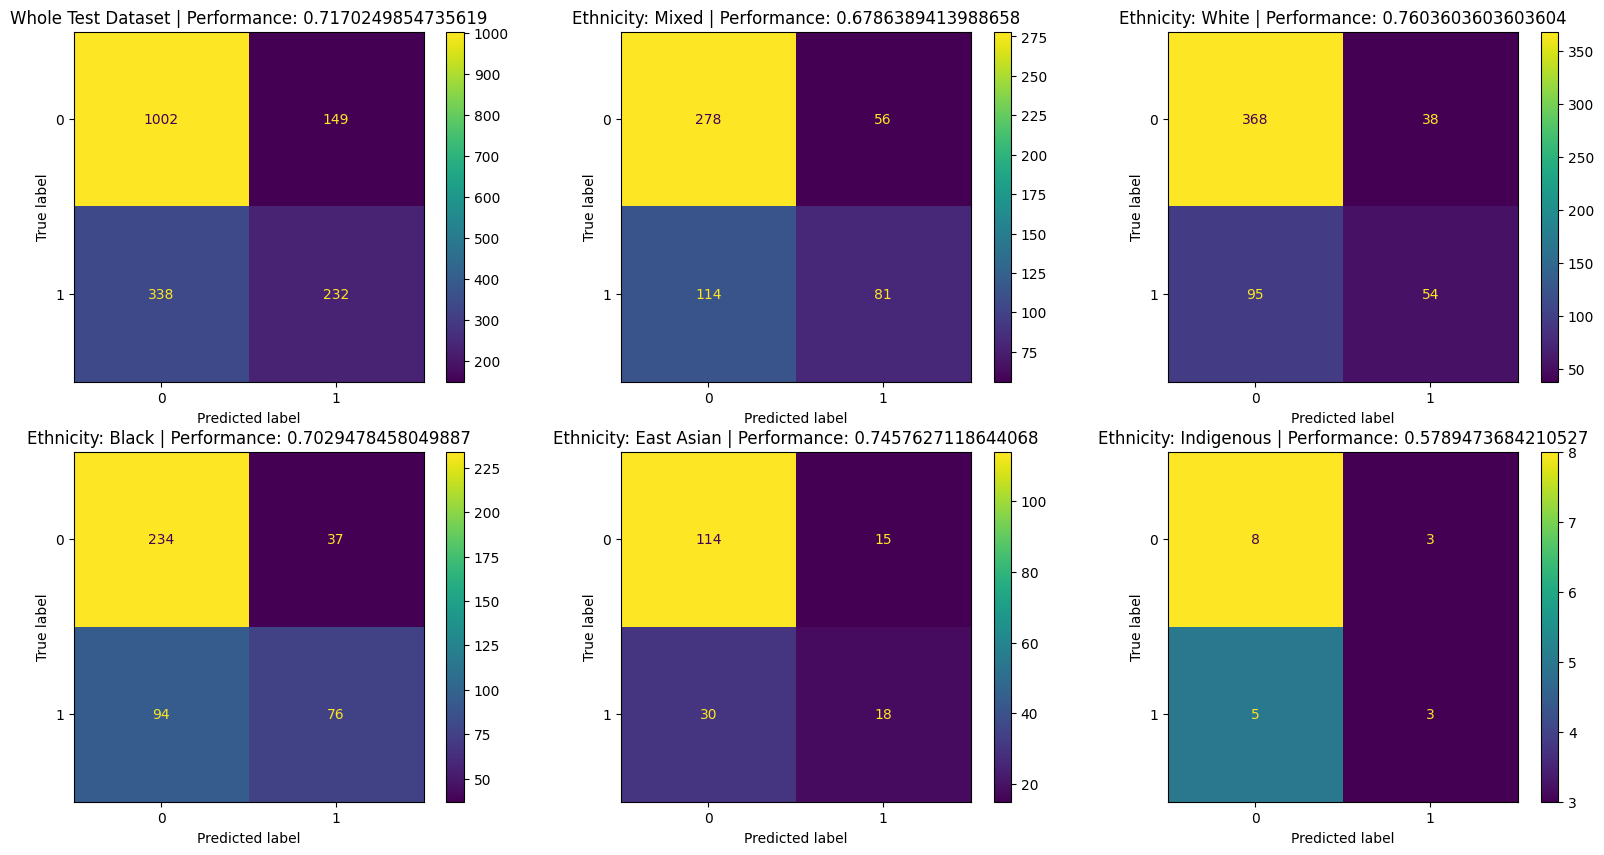

In [7]:
syn_y = syn_data["is_dead_at_time_horizon=14"]
syn_X_in = syn_data.drop(columns=["is_dead_at_time_horizon=14"])

syn_X_train, syn_X_test, syn_y_train, syn_y_test = train_test_split(syn_X_in, syn_y, random_state=4)
syn_X_train.reset_index(drop=True, inplace=True)
syn_X_test.reset_index(drop=True, inplace=True)
syn_y_train.reset_index(drop=True, inplace=True)
syn_y_test.reset_index(drop=True, inplace=True)

# Train model on whole dataset
xgb_model = xgb.XGBClassifier(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8, 
    colsample_bytree=1, 
    gamma=1, 
    objective="binary:logistic",
    random_state=42,
)
xgb_model.fit(syn_X_train, syn_y_train)

ethnicity_idxes = syn_X_in["Ethnicity"].unique()
ethnicity_idxes.sort()
ethnicities = [ethnicity_mapper[e] for e in ethnicity_idxes]

calculated_accuracy_score = accuracy_score(syn_y_train, xgb_model.predict(syn_X_train))
print(f"evaluating train set: {calculated_accuracy_score}")
syn_y_pred = xgb_model.predict(syn_X_test)
calculated_accuracy_score = accuracy_score(syn_y_test, syn_y_pred)


f, axes = plt.subplots(2, 3, figsize=(20, 10))

cm = confusion_matrix(syn_y_test, syn_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
disp.plot(ax=axes[0,0])
disp.ax_.set_title(f"Whole Test Dataset | Performance: {calculated_accuracy_score}")

for ethnicity_idx in ethnicity_idxes:
    syn_X_test_per_ethnicity = syn_X_test.loc[syn_X_test["Ethnicity"] == ethnicity_idx]
    test_records_per_ethnicity_indicies = syn_X_test_per_ethnicity.index

    syn_y_pred = xgb_model.predict(syn_X_test_per_ethnicity)
    syn_y_true = syn_y_test.iloc[test_records_per_ethnicity_indicies]

    calculated_accuracy_score = accuracy_score(syn_y_true, syn_y_pred)

    cm = confusion_matrix(syn_y_true, syn_y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
    ax_index = [0, ethnicity_idx + 1] if ethnicity_idx <= 1 else [1, (ethnicity_idx + 1) % 3]
    disp.plot(ax=axes[ax_index[0], ax_index[1]])
    disp.ax_.set_title(f"Ethnicity: {ethnicity_mapper[ethnicity_idx]} | Performance: {calculated_accuracy_score}")
plt.show()

As you can see the new model trained on the synthetic data performs more similarly across the different populations. 

Why not play with the different synthetic data generation methods and their parameters to see if you can achieve the same improvement in fairness, but with a higher performance? If you need help identifying the right methods then, remember you can list the available plugins with `Plugins().list()` and to learn what they do refer to the [docs](https://synthcity.readthedocs.io/en/latest/generators.html).

# Removing bias via causal generation with DECAF
### Load the data
Lets load the data from file again to make sure we are working with the correct data and nothing has changed. As before we willconstruct it as a classification problem.

```DP_score requires splitting the dataset into 1s and 0s```

In [8]:
time_horizon = 14
X = pd.read_csv(f"../data/Brazil_COVID/covid_normalised_numericalised.csv")

X.loc[(X["Days_hospital_to_outcome"] <= time_horizon) & (X["is_dead"] == 1), f"is_dead_at_time_horizon={time_horizon}"] = 1
X.loc[(X["Days_hospital_to_outcome"] > time_horizon), f"is_dead_at_time_horizon={time_horizon}"] = 0
X.loc[(X["is_dead"] == 0), f"is_dead_at_time_horizon={time_horizon}"] = 0
X[f"is_dead_at_time_horizon={time_horizon}"] = X[f"is_dead_at_time_horizon={time_horizon}"].astype(int)

X.drop(columns=["is_dead", "Days_hospital_to_outcome"], inplace=True) # drop survival columns as they are not needed for a classification problem

loader = GenericDataLoader(
    X,
    target_column="is_dead_at_time_horizon=14",
    sensitive_features=["Ethnicity"],
    # sensitive_features=["Age", "Sex", "Ethnicity", "Region"], # How to handle multiple sensitive columns?
    random_state=42,
)

display(loader.dataframe())

,Age,Sex,Ethnicity,Region,Fever,Cough,Sore_throat,Shortness_of_breath,Respiratory_discomfort,SPO2,...,Cardiovascular,Asthma,Diabetis,Pulmonary,Immunosuppresion,Obesity,Liver,Neurologic,Renal,is_dead_at_time_horizon=14
0,1,0,0,2,1,1,0,1,1,1,...,0,1,0,0,0,0,0,0,0,0
1,75,0,0,2,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,61,1,0,2,1,1,0,1,0,0,...,1,0,1,0,0,0,0,0,0,1
3,81,1,0,2,1,1,0,1,1,1,...,1,0,1,0,0,0,0,0,0,1
4,86,0,0,2,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6877,52,0,0,4,1,1,0,1,1,1,...,0,0,1,0,0,0,0,0,0,0
6878,34,1,1,4,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6879,44,1,1,4,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6880,23,1,1,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Generate synthetic data

### Create and fit syn_model using DECAF

In [10]:
prefix = "fairness.causal_generation"
model = "decaf"
n_iter = 20
count = 6882 # set the count equal to the number of rows in the original dataset
print(model)

save_file = Path("saved_models") / f"{prefix}_{model}_n_iter={n_iter}_numericalised.bkp"
if Path(save_file).exists():
    syn_model = serialization.load_from_file(save_file)
else:
    # syn_model = Plugins().get(model, n_iter=n_iter, struct_learning_enabled=True) # Pass struct_learning_enabled=True in order for the syn_model to learn the Dag
    syn_model = decaf_plugin(struct_learning_enabled=True, n_iter=n_iter)
    dag_before = syn_model.get_dag(loader.dataframe())
    syn_model.fit(loader, dag=dag_before)
    print(syn_model.get_dag(loader.dataframe()))
    serialization.save_to_file(save_file, syn_model)

decaf
[('Age', 'is_dead_at_time_horizon=14'), ('Age', 'Cardiovascular'), ('Age', 'Diabetis'), ('Age', 'Region'), ('Age', 'Neurologic'), ('Age', 'Sex'), ('Age', 'Renal'), ('Age', 'Fever'), ('Age', 'Pulmonary'), ('Age', 'Obesity'), ('Age', 'Vomitting'), ('Age', 'Asthma'), ('Age', 'Immunosuppresion'), ('Age', 'Liver'), ('is_dead_at_time_horizon=14', 'SPO2'), ('Region', 'Ethnicity'), ('Region', 'Sore_throat'), ('Fever', 'Cough'), ('Vomitting', 'Dihareea'), ('SPO2', 'Respiratory_discomfort'), ('Respiratory_discomfort', 'Shortness_of_breath')]


100%|██████████| 1000/1000 [03:00<00:00,  5.53it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | generator     | Generator_causal | 2.3 M 
1 | discriminator | Discriminator    | 281 K 
---------------------------------------------------
2.6 M     Trainable params
3.5 K     Non-trainable params
2.6 M     Total params
10.458    Total estimated model params size (MB)


Epoch 19: 100%|██████████| 108/108 [00:04<00:00, 22.97it/s, loss=-0.395] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 108/108 [00:04<00:00, 22.71it/s, loss=-0.395]
[('Age', 'is_dead_at_time_horizon=14'), ('Age', 'Cardiovascular'), ('Age', 'Diabetis'), ('Age', 'Region'), ('Age', 'Neurologic'), ('Age', 'Sex'), ('Age', 'Renal'), ('Age', 'Fever'), ('Age', 'Pulmonary'), ('Age', 'Obesity'), ('Age', 'Vomitting'), ('Age', 'Asthma'), ('Age', 'Immunosuppresion'), ('Age', 'Liver'), ('is_dead_at_time_horizon=14', 'SPO2'), ('Region', 'Ethnicity'), ('Region', 'Sore_throat'), ('Fever', 'Cough'), ('Vomitting', 'Dihareea'), ('SPO2', 'Respiratory_discomfort'), ('Respiratory_discomfort', 'Shortness_of_breath')]


In [11]:
bias={"Ethnicity": ["is_dead_at_time_horizon=14"]} # This will probably need to be column indices
decaf_syn_data = syn_model.generate(count, biased_edges=bias)
print(syn_model.get_dag(decaf_syn_data.dataframe()))
# display(decaf_syn_data)
# display(decaf_syn_data["Ethnicity"].value_counts())

[('Dihareea', 'Vomitting'), ('Dihareea', 'Diabetis'), ('Dihareea', 'Ethnicity'), ('Diabetis', 'Cardiovascular'), ('Diabetis', 'Age'), ('Ethnicity', 'Region'), ('Region', 'Sex')]


,Age,Sex,Ethnicity,Region,Fever,Cough,Sore_throat,Shortness_of_breath,Respiratory_discomfort,SPO2,...,Cardiovascular,Asthma,Diabetis,Pulmonary,Immunosuppresion,Obesity,Liver,Neurologic,Renal,is_dead_at_time_horizon=14
0,77,0,2,2,1,1,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0
1,14,0,2,4,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,76,0,2,4,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,60,1,2,4,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,56,0,2,4,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6877,99,0,0,2,1,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
6878,48,0,2,4,1,1,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0
6879,18,0,2,4,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
6880,76,0,0,2,1,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


2    5163
0    1719
Name: Ethnicity, dtype: int64

## DECAF fairness tests
### 1) Fairness through Unawareness
Average the pair-wise values for a single column
### 2) Demographic Parity
### 3) Conditional Fairness?

In [45]:
def FTU_score(loader):

    # Input: data to be evaluated (synthetic or real)

    # Split the data into D_tr and D_eval for training and validation
    X, y = loader[loader.static_features].copy(), loader[loader.target_column].copy()
    X.drop(columns=["is_dead_at_time_horizon=14"], inplace=True)
    X_train, X_eval, y_train, y_eval = train_test_split(X, y, train_size=0.6, random_state=4)
    X_train.reset_index(drop=True, inplace=True)
    X_eval.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    y_eval.reset_index(drop=True, inplace=True)

    # Train a classifier on D_tr to learn prediction rule (X, A) -> Y
    xgb_model = xgb.XGBClassifier(
        n_estimators=500,
        learning_rate=0.01,
        max_depth=3,
        subsample=0.8, 
        colsample_bytree=1, 
        gamma=1, 
        objective="binary:logistic",
        random_state=42,
    )
    xgb_model.fit(X_train, y_train)

    # Check classifier
    # from sklearn.metrics import classification_report
    # syn_y_pred = xgb_model.predict(X_eval) 
    # print(classification_report(y_eval, syn_y_pred))

    # for each pair of feature values
    ftu_list = []
    sensitive_feature_values = loader[loader.sensitive_features[0]].unique()
    for val1, val2 in itertools.combinations(sensitive_feature_values,2):
        # Create a new dataset D_eval(1) by setting A := 1 for all records in D_eval, the X is kept the same.
        # Create D_eval(0) similarly.
        X_eval_1 = X_eval.copy()
        X_eval_2 = X_eval.copy()

        X_eval_1[loader.sensitive_features[0]] = val1
        X_eval_2[loader.sensitive_features[0]] = val2
    
        # Pass D_eval(1) to the classifier to get predictions \hat{Y}(1). 
        # Similarly, make predictions on D_eval(0) to get \hat{Y}(0).
        y_hat_1 = xgb_model.predict(X_eval_1)
        y_hat_2 = xgb_model.predict(X_eval_2)

        # Calculate the proportion of \hat{Y}(1) = 1, denoted as P1.
        # Calculate the proportion of \hat{Y}(0) = 1, denoted as P0.
        p1 = y_hat_1.sum() / len(y_hat_1)
        p2 = y_hat_2.sum() / len(y_hat_2)

        # FTU = abs(P0 - P1)
        ftu = abs(p1 - p2)
        ftu_list.append(ftu)
    return np.median(ftu_list)

def demographic_parity_score(loader):

    # Input: data to be evaluated (synthetic or real)

    # Split the data into D_tr and D_eval for training and validation
    X, y = loader[loader.static_features].copy(), loader[loader.target_column].copy()
    X.drop(columns=["is_dead_at_time_horizon=14"], inplace=True)
    X_train, X_eval, y_train, y_eval = train_test_split(X, y, train_size=0.6, random_state=4)
    X_train.reset_index(drop=True, inplace=True)
    X_eval.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    y_eval.reset_index(drop=True, inplace=True)

    # Train a classifier on D_tr to learn prediction rule (X, A) -> Y
    xgb_model = xgb.XGBClassifier(
        n_estimators=200,
        learning_rate=0.01,
        max_depth=3,
        subsample=0.8, 
        colsample_bytree=1, 
        gamma=1, 
        objective="binary:logistic",
        random_state=42,
    )
    xgb_model.fit(X_train, y_train)

    # Check classifier
    # from sklearn.metrics import classification_report
    # syn_y_pred = xgb_model.predict(X_eval) 
    # print(classification_report(y_eval, syn_y_pred))

    # for each pair of feature values
    demographic_parity_list = []
    sensitive_feature_values = loader[loader.sensitive_features[0]].unique()
    for val1, val2 in itertools.combinations(sensitive_feature_values,2):

        # Create a new dataset D_eval(1) by only keeping the records in D_eval that have A = 1. Remove the records with A = 0.
        # Create D_eval(0) similarly.
        X_eval_0 = X_eval.loc[X_eval[loader.sensitive_features[0]] == val1].copy()
        X_eval_1 = X_eval.loc[X_eval[loader.sensitive_features[0]] == val2].copy()
        # display(X_eval_0)
        # display(X_eval_1)

        # Pass D_eval(1) to the classifier to get predictions \hat{Y}(1). 
        # Similarly, make predictions on D_eval(0) to get \hat{Y}(0).
        y_hat_0 = xgb_model.predict(X_eval_0)
        y_hat_1 = xgb_model.predict(X_eval_1)

        # Calculate the proportion of \hat{Y}(1) = 1, denoted as P1.
        # Calculate the proportion of \hat{Y}(0) = 1, denoted as P0.
        p0 = y_hat_0.sum() / len(y_hat_0)
        p1 = y_hat_1.sum() / len(y_hat_1)

        # DP = abs(P0 - P1)
        DP = abs(p0 - p1)
        demographic_parity_list.append(DP)
    return np.mean(demographic_parity_list)

FTU_score_gt = FTU_score(loader)
FTU_score_syn = FTU_score(decaf_syn_data)

print(f"Fairness through unawareness scores \nreal data:{FTU_score_gt} | synthetic data:{FTU_score_syn}")

demographic_parity_score_gt = demographic_parity_score(loader)
demographic_parity_score_syn = demographic_parity_score(decaf_syn_data)

print(f"Demographic Parity scores \nreal data:{demographic_parity_score_gt} | synthetic data:{demographic_parity_score_syn}")

Fairness through unawareness scores 
real data:0.01834362513621504 | synthetic data:0.0
Demographic Parity scores 
real data:0.14552510430923596 | synthetic data:0.0


# Some visualizations